In [ ]:
# default_exp models.dnn

In [ ]:
# hide
import sys

sys.path.append("..")

# DNN model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
class DNN(torch.nn.Module):
    """Implements a simple `DNN` architecture for time series forecasting. Inherits 
    from pytorch `Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`_.
    
    Arguments:
        * input_channels (int): Number of covariates in input time series.
        * output_channels (int): Number of target time series.
        * horizon (int): Number of time steps to forecast.
        * lookback (int): Number of time steps to lookback.
        * hidden_channels (int): Number of channels in convolutional hidden layers.
        * p_dropout (float): Probality of dropout.
    """
    def __init__(self,
                 input_channels,
                 output_channels,
                 horizon,
                 lookback,
                 hidden_channels=64,
                 p_dropout=.2,
                ):
        """Inititalize variables."""
        super(DNN, self).__init__()
        self.output_channels = output_channels
        self.horizon = horizon
        self.hidden_channels = hidden_channels

        # Set up first layer for input
        ks = 3
        conv_input = torch.nn.Conv1d(
            in_channels=input_channels,
            out_channels=hidden_channels,
            kernel_size=ks,
            padding=(ks-1)//2
        )
        
        # Set up nonlinear output layers
        self.body = nn.Sequential(conv_input,Flatten())          
        self.dnn = LinBnDrop((hidden_channels*lookback),horizon*output_channels)

    def forward(self, inputs):
        """Forward function."""
        hid = self.body(inputs.float())
        return self.dnn(hid).view(hid.size(0),self.output_channels,-1).float()
    
    @property
    def n_parameters(self):
        """Returns the number of model parameters."""
        par = list(self.parameters())
        s = sum([np.prod(list(d.size())) for d in par])
        return s


# Test

In [ ]:
# hide
horizon = 12
lookback = 128
model = DNN(input_channels=2,
            output_channels=1,
            horizon=horizon,
            lookback = lookback,
            )
with torch.no_grad():
    test_eq(model(tensor(np.random.rand(64,2,lookback))).shape, (64,1,horizon))
    

In [ ]:
# hide
horizon = 14
lookback = 12
model = DNN(input_channels=1,
            output_channels=1,
            horizon=horizon,
            lookback = lookback,
            )

with torch.no_grad():
    test_eq(model(tensor(np.random.rand(64,1,lookback))).shape, (64,1,horizon))

In [ ]:
# hide
horizon = 14
lookback = 12
out_channels = 2
model = DNN(input_channels=1,
            output_channels=out_channels,
            horizon=horizon,
            lookback = lookback,
            )

with torch.no_grad():
    test_eq(model(tensor(np.random.rand(64,1,lookback))).shape, (64,out_channels,horizon))

In [ ]:
horizon = 12
lookback = 128

In [ ]:
# hide
from fastseq.data.load import *
from fastseq.data.transforms import *
from fastai2.data.all import *

In [ ]:
t = np.arange(1000)
lenghts = np.random.randint(10,500,10000)
data_train = [np.array([i+.5*np.sin(t[:l]),
              t[:l]+(0.1*np.random.randn()),
             ])
              for i,l in enumerate(lenghts)]

# print([d.shape for d in data_train])

In [ ]:
ts_ds = TimeSeriesDataset(
    data_train,
    lookback,
    horizon,
    step=1,
    static_covs = [1,2,2,2,2],
    transform = ToTensor()
)
ts_dl = DataLoader(
    ts_ds,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=1
)

Dropped 47/10000 time series due to length.


In [ ]:
model = DNN(input_channels=2,
            output_channels=2,
            horizon=horizon,
            lookback = lookback,
           )

print('Number of model parameters: {}.'.format(model.n_parameters))

# # .. and the loss
# loss = torch.distributions.StudentT

Number of model parameters: 213440.


In [ ]:
data = DataBunch(ts_dl, ts_dl).cuda()
learn = Learner(data, model, loss_func=F.mse_loss, opt_func=Adam, metrics=accuracy)

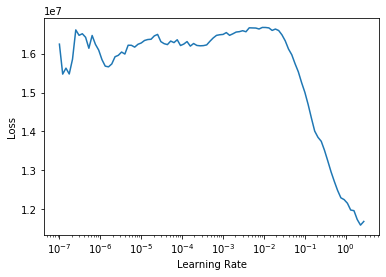

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
This cell doesn't have an export destination and was ignored:
 
Converted 02_deep4cast_m4_example.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.dnn.ipynb.
Converted 05_models.wavenet.ipynb.
Converted index.ipynb.
